## Q3: Effects of Training Data Choices on Neural Network Performance
## Research Question 
How do choices about data such as:
 i) amount of training data
 ii) balance of classes in a classification problem
affect the performance of a neural network for predicting space mission success?

In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from py.functions import load_missions_csv, preprocess_missions, train_test

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2025-12-17 14:52:09.397387: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 14:52:09.397761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 14:52:23.914504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 14:52:33.955813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
#loading raw dataset
df = load_missions_csv("../data/mission_launches.csv")

#preprocess into features (X) and labels(y)
X, y = preprocess_missions(df)

#train and test split
X_train, X_test, y_train, y_test, scaler = train_test(X, y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class balance:\n", y.value_counts())

Train shape: (766, 80)
Test shape: (192, 80)
Class balance:
 y
1    906
0     52
Name: count, dtype: int64


In [ ]:
def build_nn(input_dim): #same as before just as a function
    model = Sequential([
        Dense(32, activation = "relu", input_shape = (X_train.shape[1],)),
        Dense(16, activation = "relu"),
        Dense(1, activation = "sigmoid")
    ])

    model.compile(
        optimizer = "adam",
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [6]:
fractions = [0.25, 0.5, 0.75, 1.0] #setting the training fractions
results_data_amount = []

for f in fractions:
    n = int(len(X_train) * f)
    X_sub = X_train[:n]
    y_sub = y_train[:n]

    model = build_nn(X_sub.shape[1])
    model.fit(X_sub, y_sub, epochs=20, batch_size=32, verbose=0)

    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    results_data_amount.append({
        "Training Fraction": f,
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    })

pd.DataFrame(results_data_amount)


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Training Fraction,Accuracy,ROC_AUC
0,0.25,0.932292,0.500824
1,0.50,0.947917,0.613462
2,0.75,0.947917,0.593132
3,1.00,0.942708,0.644780


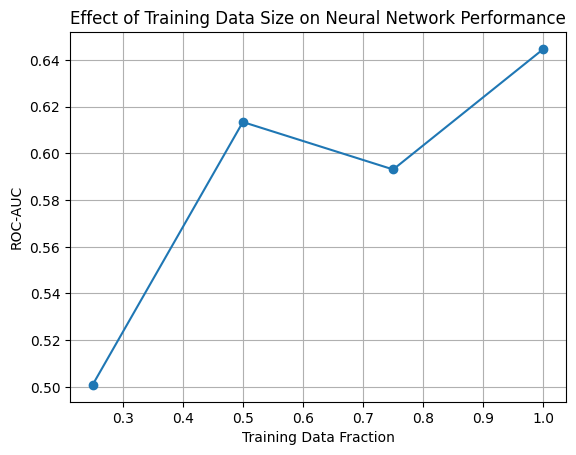

In [12]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results_data_amount)

plt.figure()
plt.plot(results_df["Training Fraction"], results_df["ROC_AUC"], marker="o")
plt.xlabel("Training Data Fraction")
plt.ylabel("ROC-AUC")
plt.title("Effect of Training Data Size on Neural Network Performance")
plt.grid(True)
plt.show()

ROC-AUC increases as more training data is used. This indicates improved class separation despite accuracy remaining mostly stable

In [9]:
# combined for balancing
train_data = pd.DataFrame(X_train)
train_data["y"] = y_train.values

# Separate classes
success = train_data[train_data["y"] == 1]
failure = train_data[train_data["y"] == 0]

#balancing the data
min_size = min(len(success), len(failure))
balanced_data = pd.concat([
    success.sample(min_size, random_state = 42),
    failure.sample(min_size, random_state = 42)
])

#balanced features and target
X_bal = balanced_data.drop(columns = ["y"]).values
y_bal = balanced_data["y"].values

#modeling with balanced X and y
model_bal = build_nn(X_bal.shape[1])
model_bal.fit(X_bal, y_bal, epochs=20, batch_size=32, verbose=0)

y_prob_bal = model_bal.predict(X_test).ravel()
y_pred_bal = (y_prob_bal >= 0.5).astype(int)

{
    "Balanced Accuracy": accuracy_score(y_test, y_pred_bal),
    "Balanced ROC_AUC": roc_auc_score(y_test, y_prob_bal)
}

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


{'Balanced Accuracy': 0.7135416666666666,
 'Balanced ROC_AUC': 0.5557692307692307}

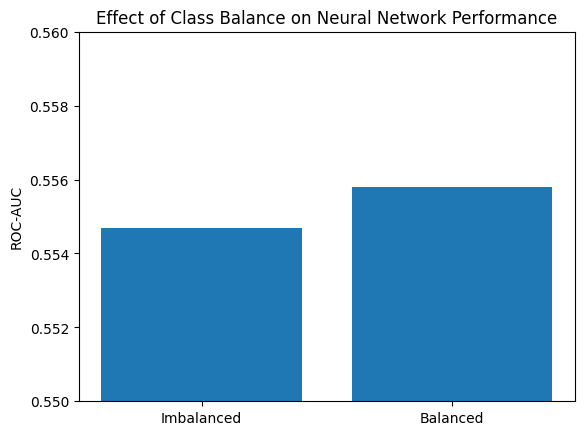

In [17]:
labels = ["Imbalanced", "Balanced"]
roc_values = [0.5547, 0.5558]  

plt.figure()
plt.bar(labels, roc_values)
plt.ylabel("ROC-AUC")
plt.title("Effect of Class Balance on Neural Network Performance")
plt.ylim(0.55, 0.56)
plt.show()


Balancing the dataset alters the model's behaviour. This shows that data composition significantly affects the performance of neual networks.

## Conclusion 

When varying the amount of training data, accuracy remains consistantly high due to class imbalance in the dataset. however, as more training data is used ROC-AUC increases. This indicates improved separation between successful and unsuccessful missions. This shows that more data helps the neural network learn more meaningful decision boundaries, even when accuracy appears vary consistant.

Balancing the training data resulted in a significant drop in accuracy and changed the model's decision making. This shows that for imbalanced classification problems, accuracy can be missleading, and highlights the importance of ROC-AUC when evaluation neural networks.

